In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# ensure the backend is set
import argparse
import torch
import keras
from torch.utils.data import DataLoader

In [2]:

import bayesflow as bf
from dl_src.load_data import data_loader
from keras.src.backend.common import global_state
global_state.set_global_attribute("torch_device", "cpu")

In [3]:
%load_ext autoreload
%autoreload 2

In [31]:
train_dataset, val_dataset, inference_variables = data_loader()


In [32]:
epochs = 30

In [37]:
summary_dim = 64 # boundary
num_blocks = 3 
num_heads = (6,) * num_blocks # boundary
embed_dims = (26,) * num_blocks
mlp_depths = (2,) * num_blocks
mlp_widths = (64,) * num_blocks
summary_dropout = 0.09
time_embedding = "time2vec"
time_embed_dim = 16 # boundary


summary_net = bf.networks.TimeSeriesTransformer(
		summary_dim=summary_dim,
		embed_dims=embed_dims,
		num_heads=num_heads,
		mlp_depths=mlp_depths,
		mlp_widths=mlp_widths,
		dropout=summary_dropout,
		time_axis=-1,
		time_embedding=time_embedding,
		time_embed_dim=time_embed_dim
	)

# Optimize hyperparameters
inf_width = 477 # boundary
inf_depth = 2 # left boundary
inf_dropout = 0.04 # left boundary
initial_learning_rate = 3.6e-4
residual = True
# spectral_normalization = trial.suggest_categorical("spectral_normalization", [True, False])

# Create inference net
sigma2 = 1
inference_network = bf.networks.ContinuousConsistencyModel(
		subnet_kwargs={
			"widths": (inf_width,)*inf_depth,
			"dropout": inf_dropout, 
			"residual": residual
		#  "spectral_normalization": spectral_normalization
		},
		sigma_data=sigma2
)

# Create optimizer
scheduled_lr = keras.optimizers.schedules.CosineDecay(
		initial_learning_rate=initial_learning_rate,
		decay_steps=epochs*train_dataset.num_batches,
		alpha=1e-8
)
optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)


# Create approximator
approximator = bf.ContinuousApproximator(
	summary_network=summary_net,
	inference_network=inference_network,
	adapter=None
)
approximator.compile(optimizer=optimizer)

In [38]:

# Train and compute the average of last 10 validation losses
history = approximator.fit(
		epochs=epochs,
		dataset=train_dataset,
		validation_data=val_dataset,
		verbose=1,
		# callbacks=[keras.callbacks.EarlyStopping(patience=5,monitor="val_loss")]
		# callbacks=[KerasPruningCallback(trial, "val_loss", interval=10)]
)


INFO:bayesflow:Fitting on dataset instance of OfflineQSPDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: -2.8282 - loss/inference_loss: -2.8282 - val_loss: -4.0397 - val_loss/inference_loss: -4.0397
Epoch 2/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: -4.2125 - loss/inference_loss: -4.2125 - val_loss: -4.4219 - val_loss/inference_loss: -4.4219
Epoch 3/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: -4.2481 - loss/inference_loss: -4.2481 - val_loss: -4.3902 - val_loss/inference_loss: -4.3902
Epoch 4/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: -4.2664 - loss/inference_loss: -4.2664 - val_loss: -4.3646 - val_loss/inference_loss: -4.3646
Epoch 5/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: -4.2480 - loss/inference_loss: -4.2480 - val_loss: -4.3990 - val_loss/inference_loss: -4.3990
Epoch 6/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: -4.2603 - loss/inference_loss: -4.2603 - val_loss: -4.3903 - val_loss/inference_loss: -4.3903
Epoch 7/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: -4.2462 -

In [39]:
summaries = []
references = []
for i in range(val_dataset.num_batches):
	batch = val_dataset[i]
	summaries.append(batch["summary_variables"])
	references.append(batch["inference_variables"])

summaries = torch.cat(summaries, dim=0)
references = torch.cat(references, dim=0)

targets = approximator._sample(num_samples=500,summary_variables=summaries)

cal_dict = bf.diagnostics.metrics.calibration_error(targets.numpy(),references.numpy())

In [40]:
cal_dict

{'values': array([0.19998772, 0.09178819, 0.03613003, 0.03200865, 0.03695367,
        0.02503523, 0.02478648, 0.08189175, 0.01374987, 0.09058023,
        0.10978542, 0.04975392, 0.07853582, 0.00918917]),
 'metric_name': 'Calibration Error',
 'variable_names': None}

In [41]:
inference_variables

['QSP/init_value/Parameter/k_C_growth',
 'QSP/init_value/Parameter/k_C_death',
 'QSP/init_value/Parameter/k_C_death_by_T',
 'QSP/init_value/Parameter/cl_Nivo',
 'QSP/init_value/Parameter/Teff_PD1_tot',
 'QSP/init_value/Parameter/C1_PDL1_tot',
 'QSP/init_value/Parameter/Kd_PD1_PDL1',
 'QSP/init_value/Parameter/K_C1_PDLX_Teff_PD1',
 'QSP/init_value/Parameter/Kd_PD1_PDL2',
 'QSP/init_value/Parameter/n_clone_p1_0',
 'QSP/init_value/Parameter/Kd_p1_0_M1',
 'QSP/init_value/Parameter/k_Teff_transmig',
 'QSP/init_value/Parameter/k_Treg_transmig',
 'QSP/init_value/Parameter/k_Teff_inhibBy_Treg']

IndexError: index 14 is out of bounds for axis 1 with size 14

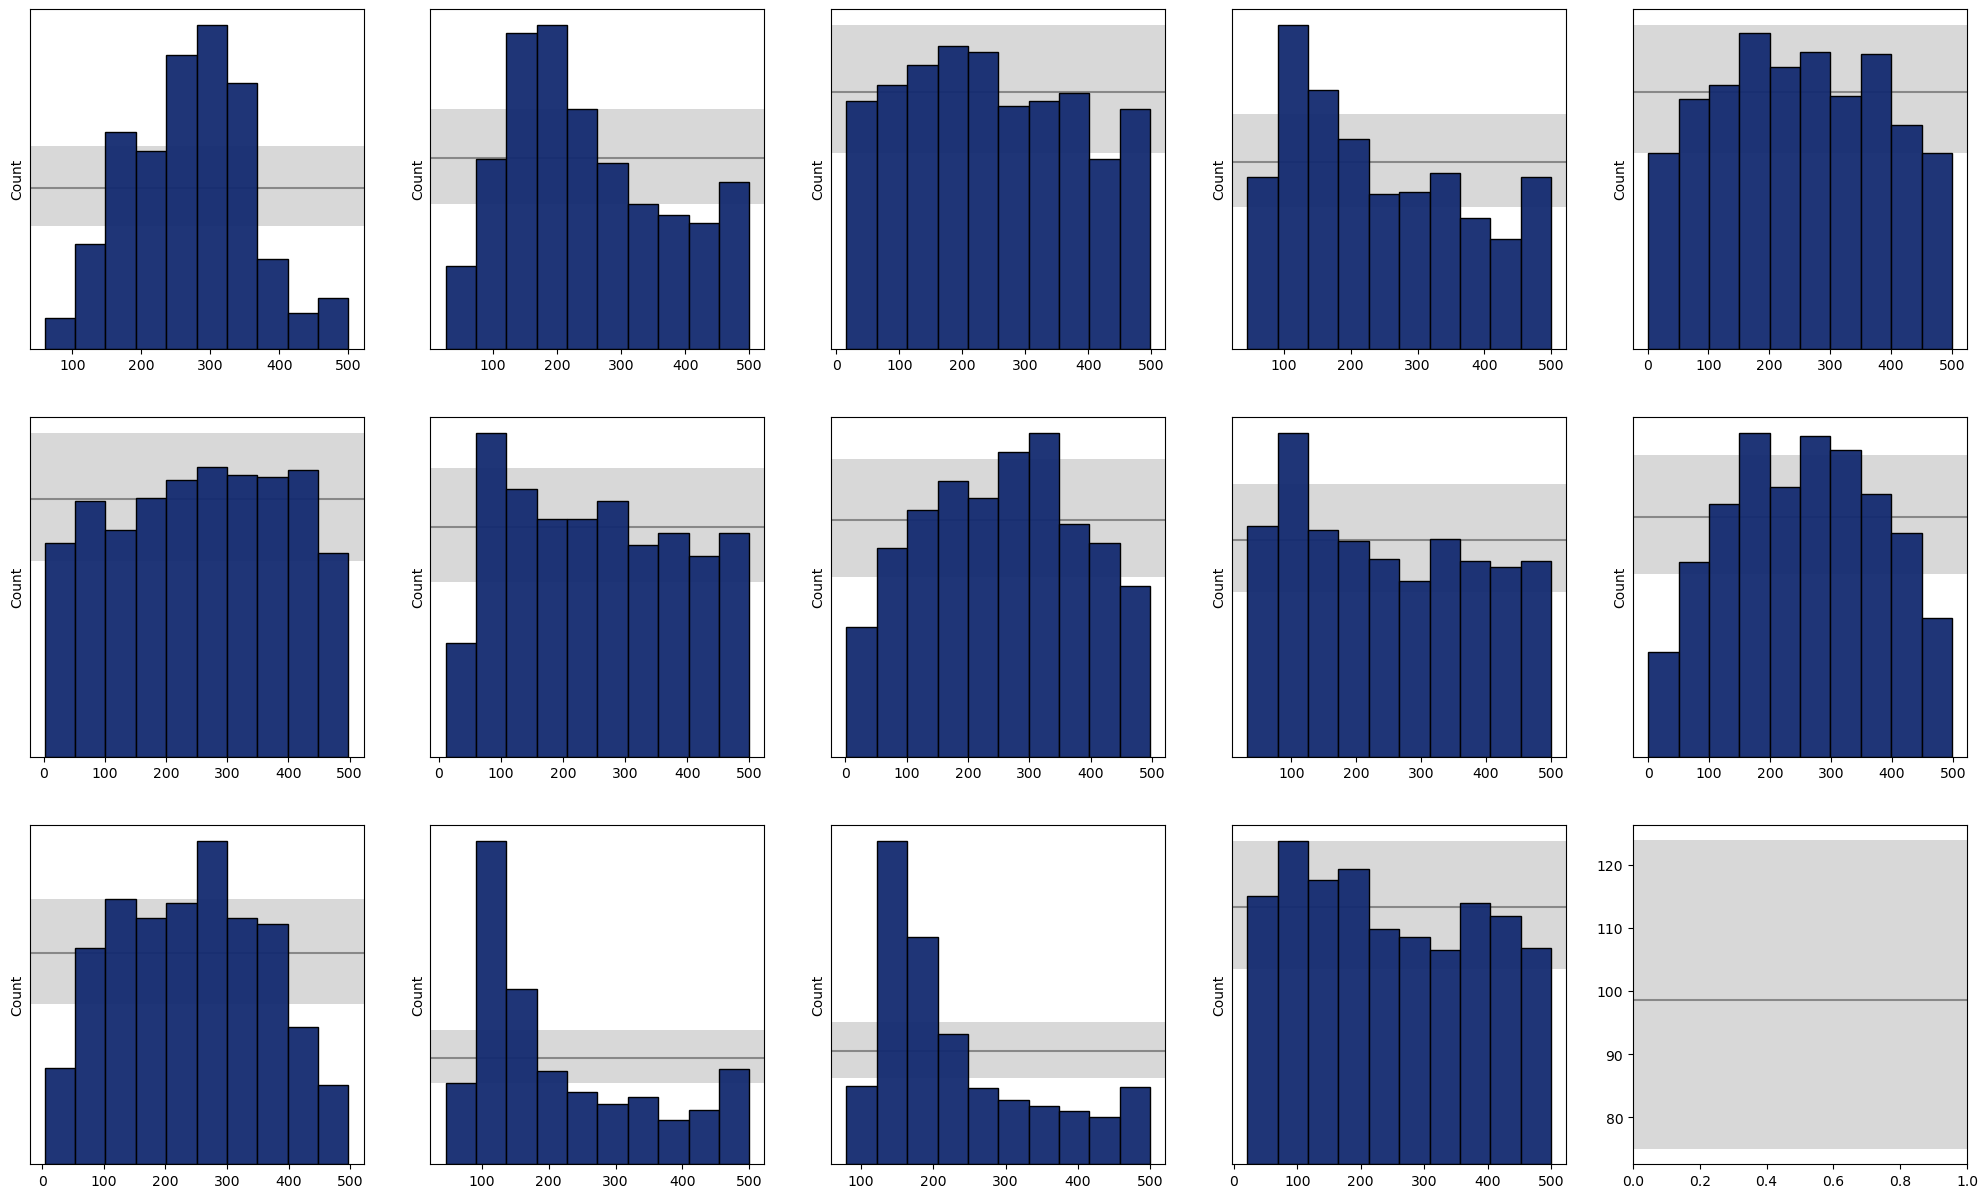

In [46]:
f = bf.diagnostics.plots.calibration_histogram(targets.numpy(),references.numpy(),variable_names=inference_variables)

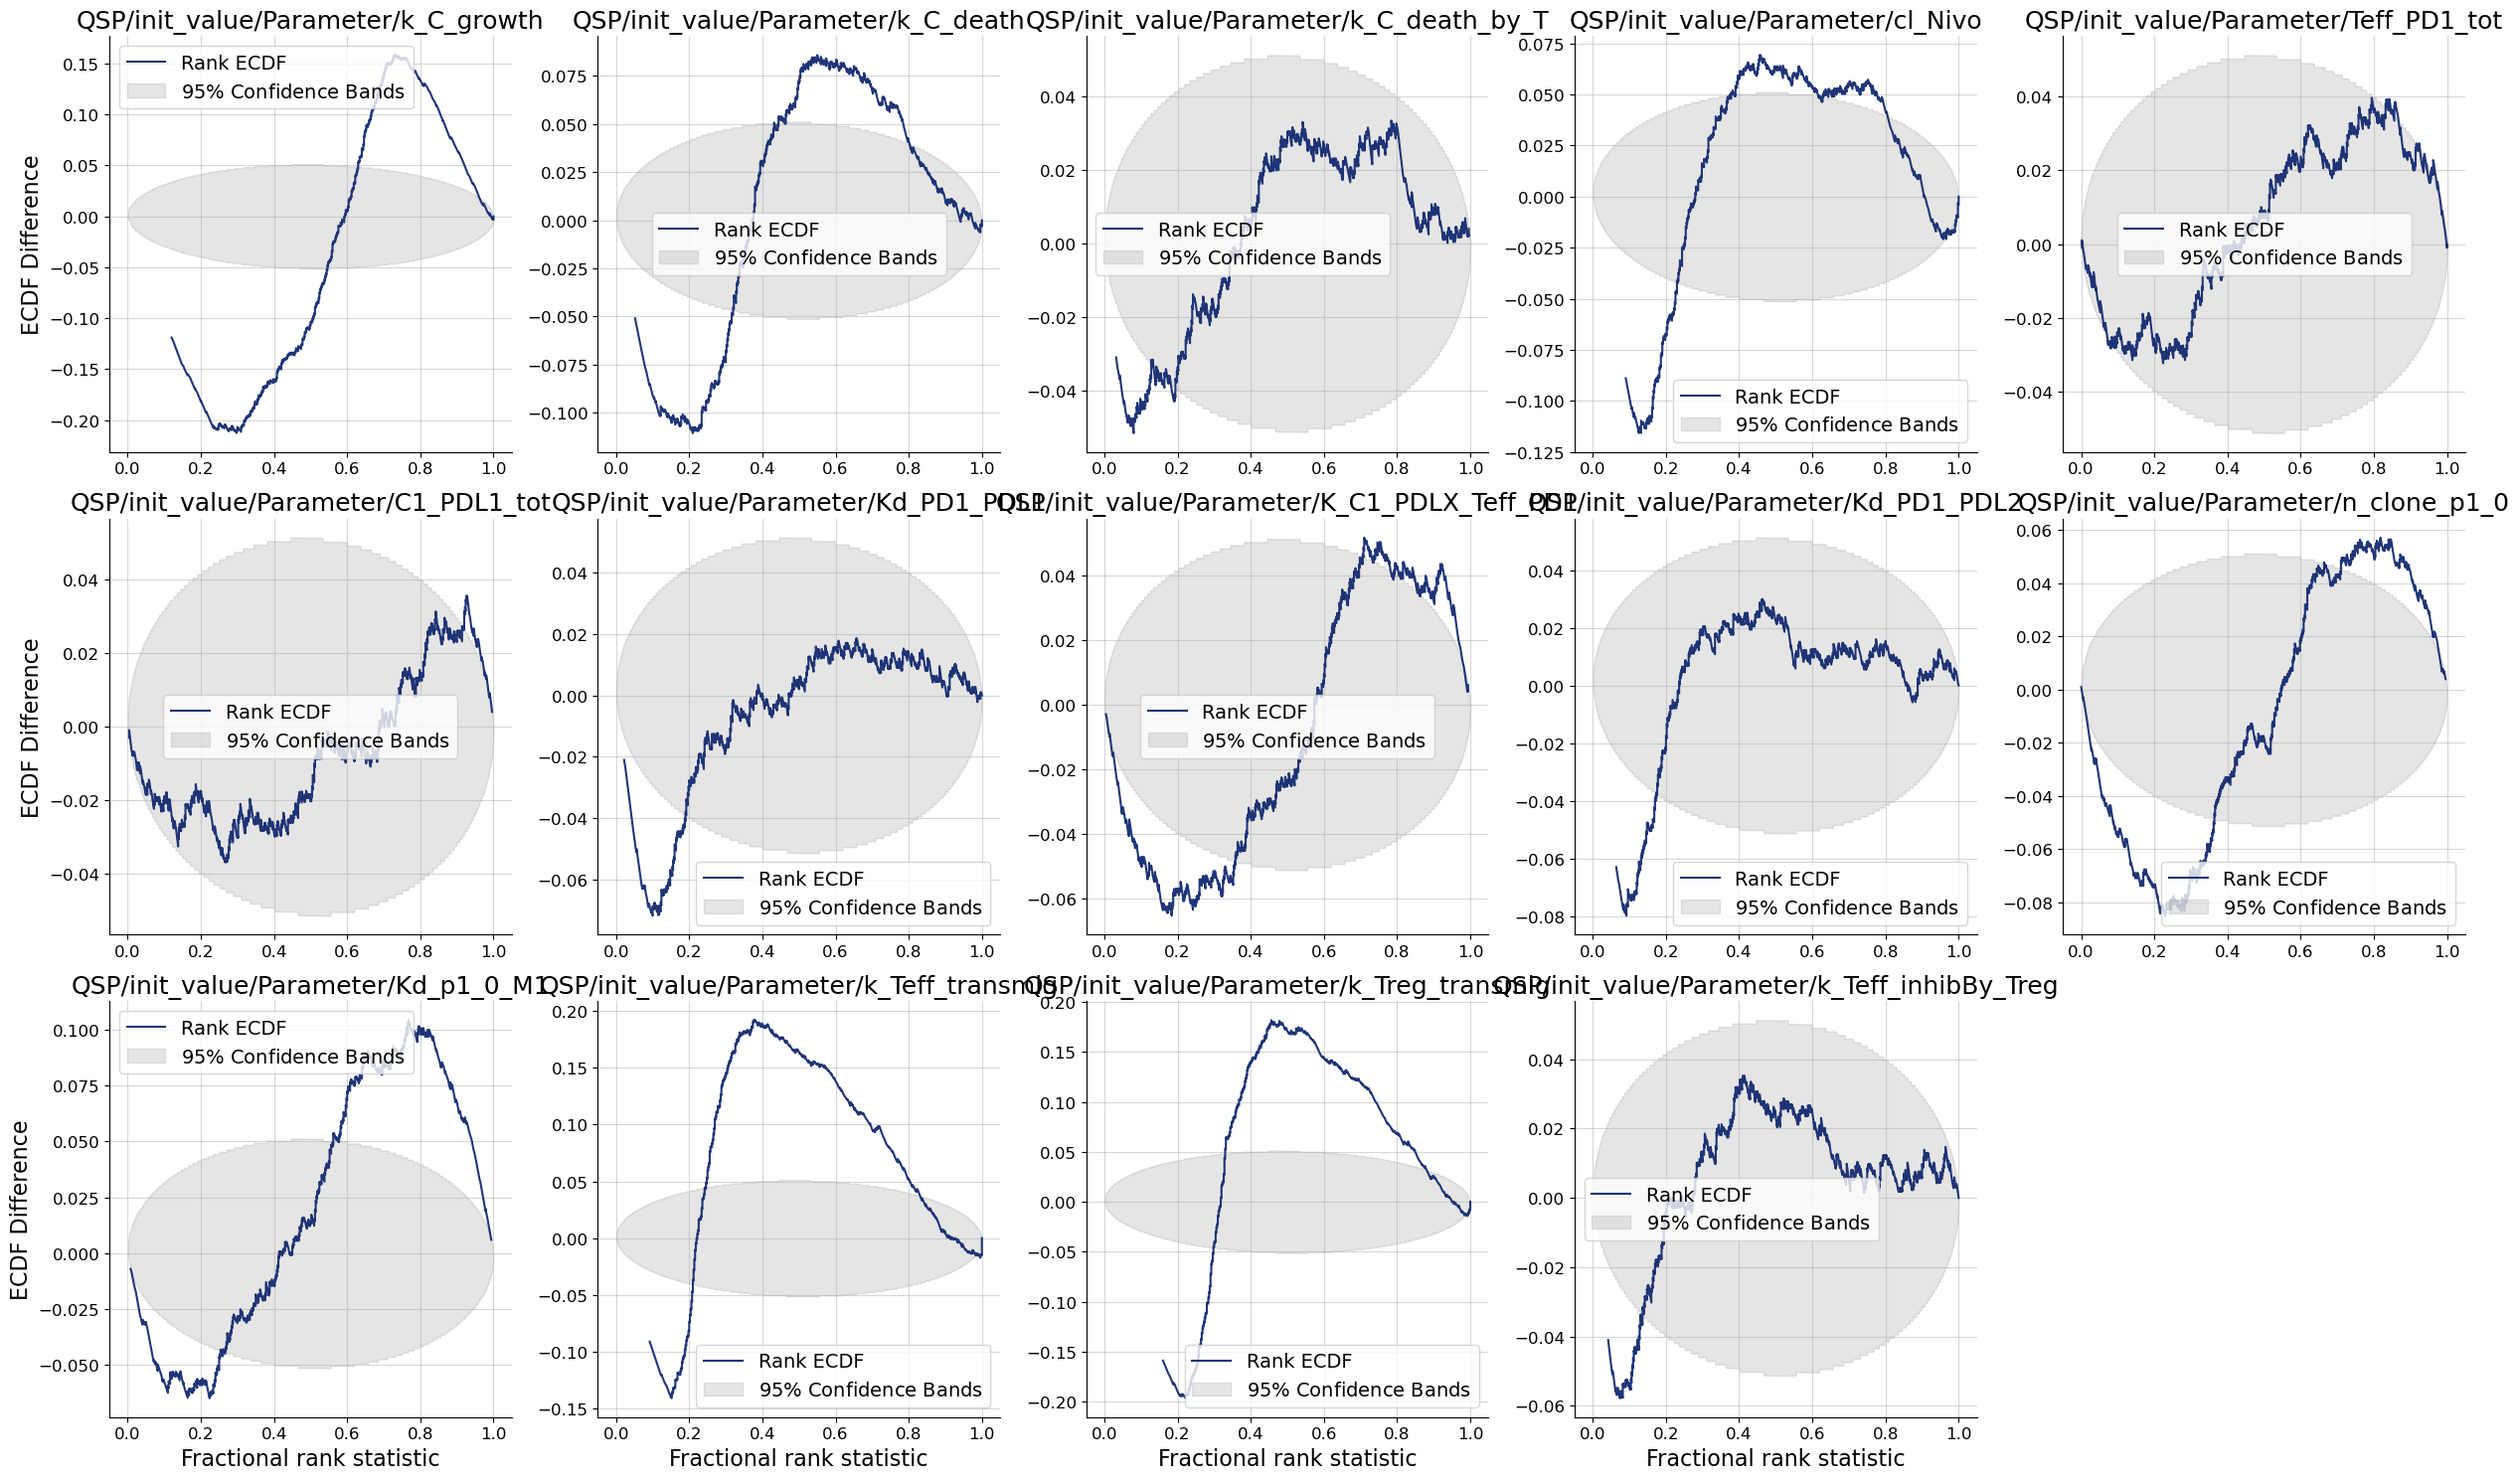

In [42]:
f = bf.diagnostics.plots.calibration_ecdf(targets.numpy(),references.numpy(),difference=True,variable_names=inference_variables)

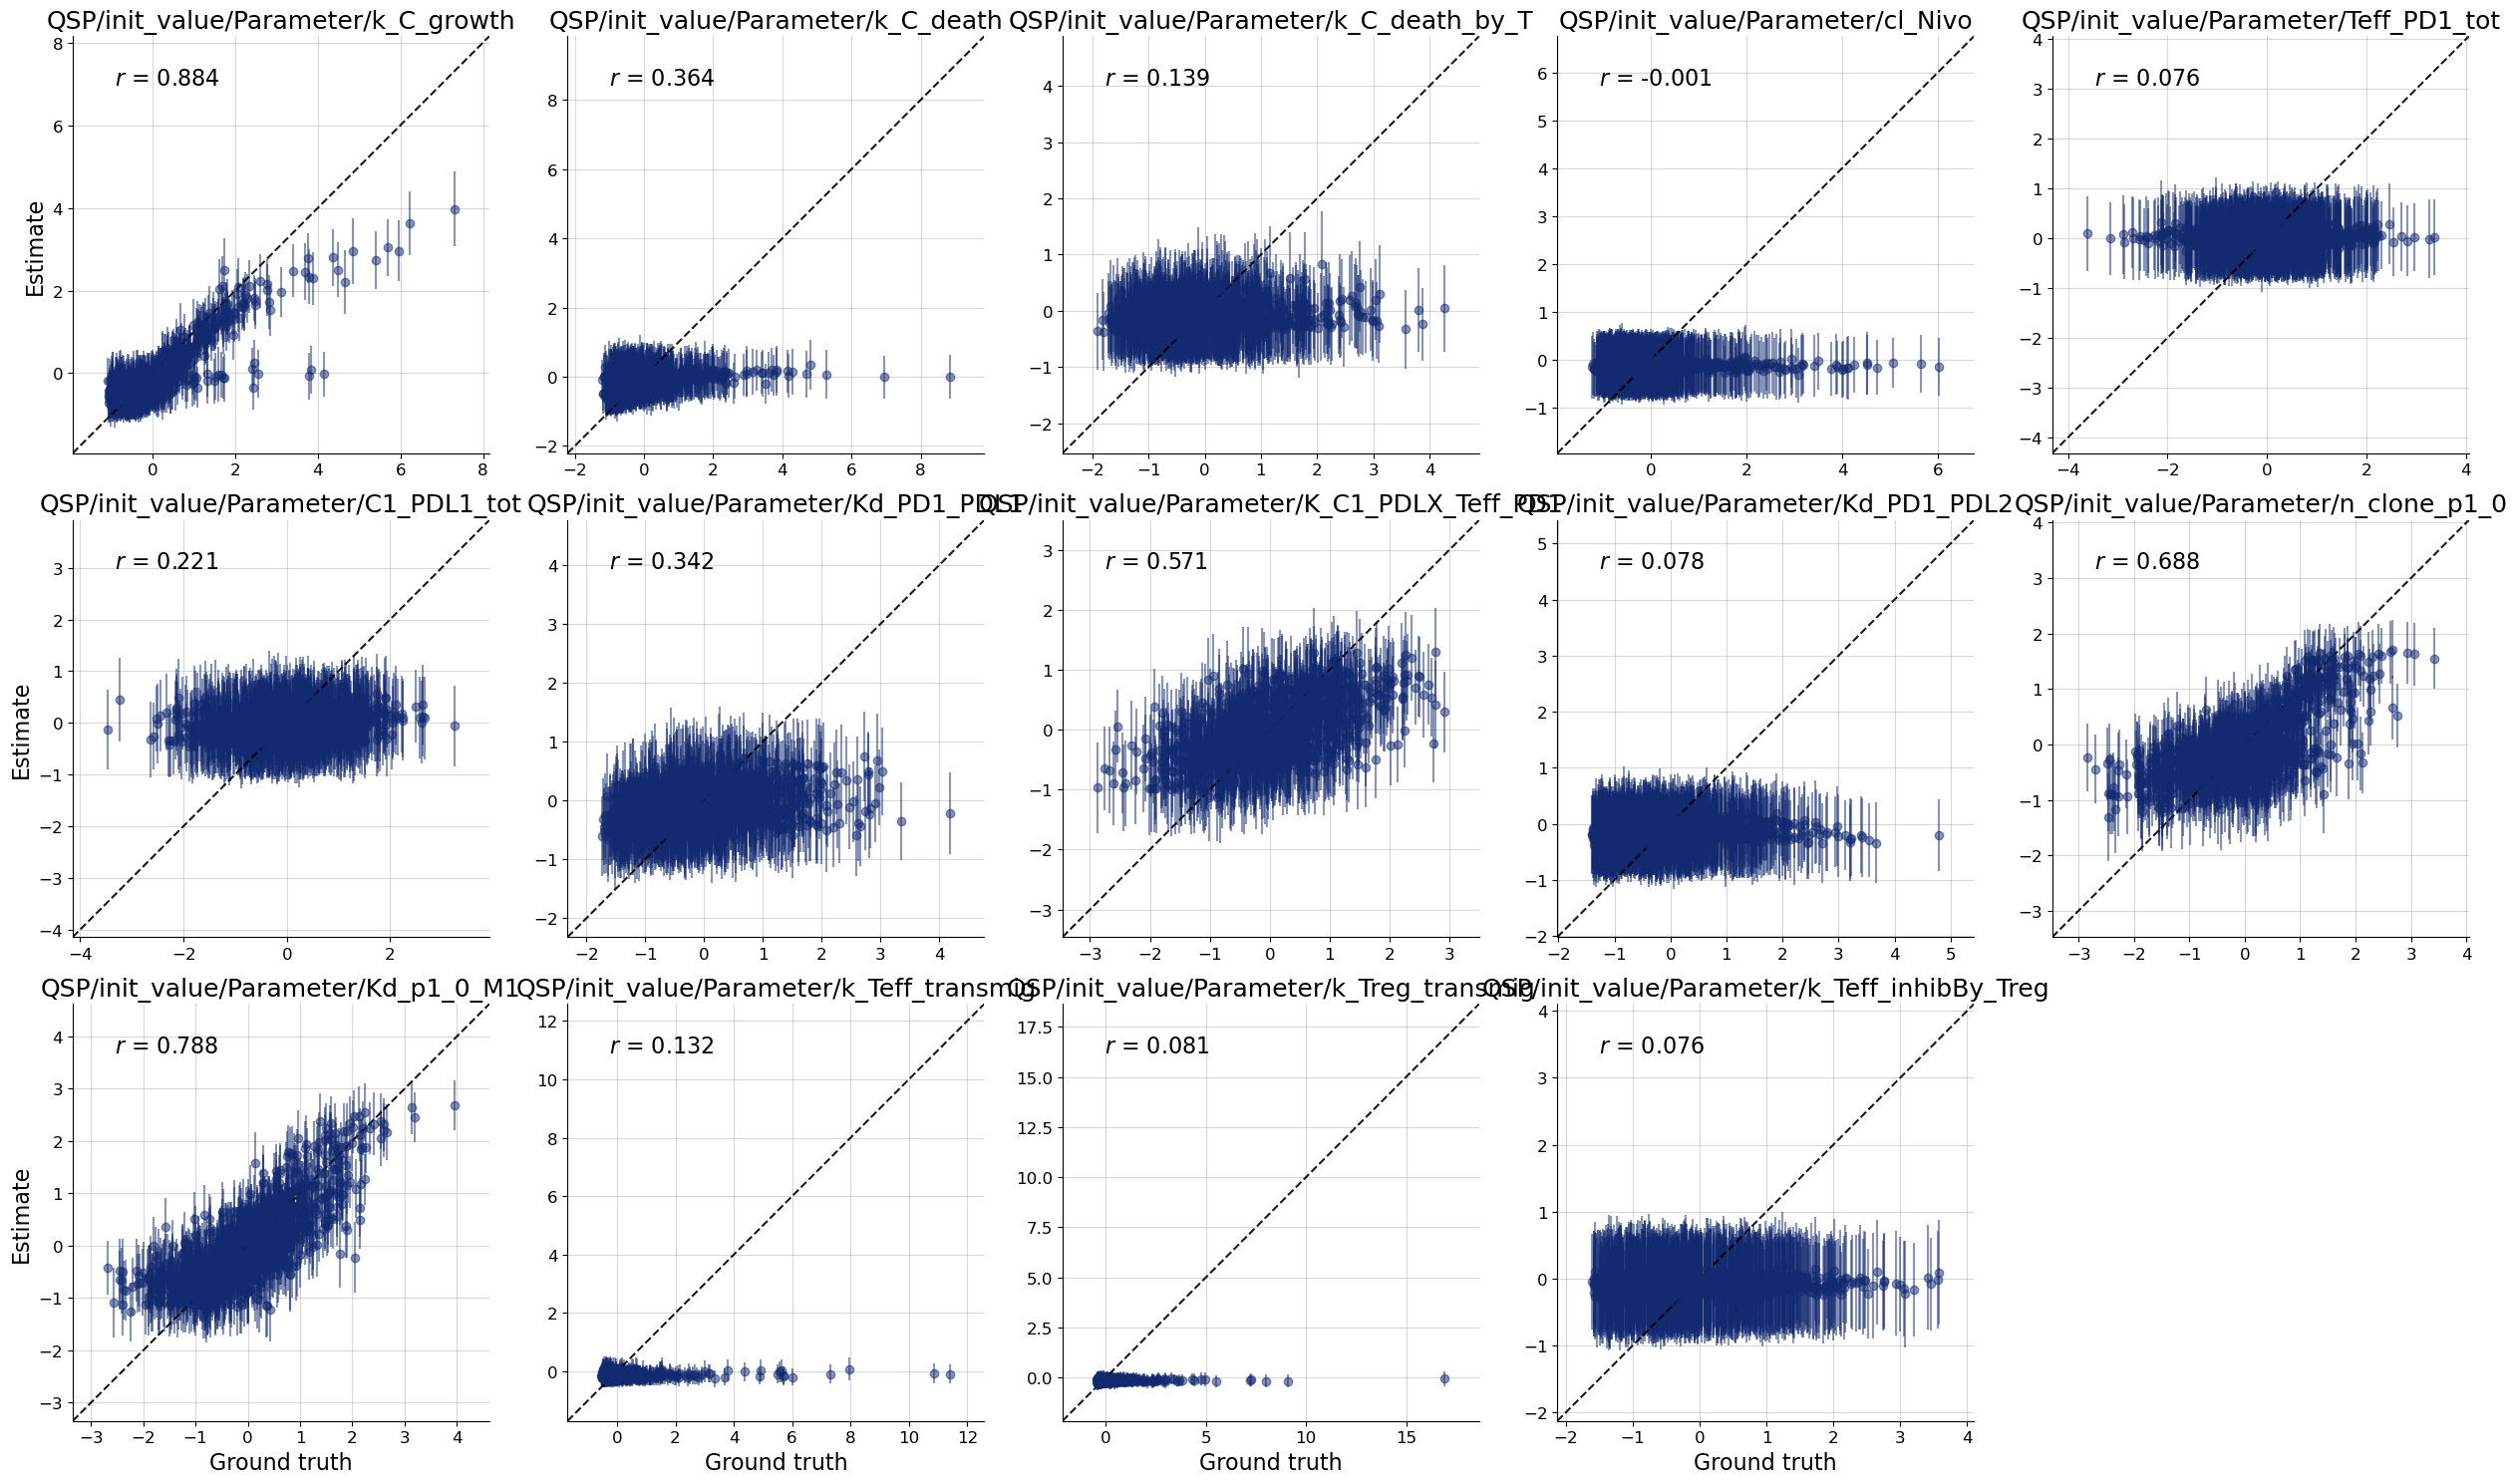

In [45]:
f = bf.diagnostics.plots.recovery(targets.numpy(),references.numpy(),variable_names=inference_variables)

In [36]:
val_dataset.params_std

tensor([9.8692e-03, 9.6212e-05, 3.3816e-01, 6.9335e-07, 1.4235e+00, 1.3702e+00,
        1.1111e+00, 1.3782e+00, 9.1590e-01, 6.7643e-01, 1.3987e+00, 5.2039e-12,
        6.5348e-12, 1.0519e+00])